In [ ]:
from google.colab import drive

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from keras.layers import Input, Embedding, Flatten, Dropout, Dense, Activation
from keras.layers import dot
from keras.models import Model
from keras.optimizers import Adam

df = pd.read_csv('/content/drive/MyDrive/OOD_LAB4_DATA/Reviews.csv')
df = df[['UserId', 'ProductId', 'Score']]
df = df.rename(columns={'Score': 'rating'})

In [ ]:
user_counts = df['UserId'].value_counts()
product_counts = df['ProductId'].value_counts()

df_filtered = df[df['UserId'].isin(user_counts[user_counts >= 50].index)]
df_filtered = df_filtered[df_filtered['ProductId'].isin(product_counts[product_counts >= 50].index)]

users = df_filtered['UserId'].unique()
products = df_filtered['ProductId'].unique()

print(f"Количество пользователей после фильтрации: {len(users)}")
print(f"Количество продуктов после фильтрации: {len(products)}")

userid2idx = {o: i for i, o in enumerate(users)}
productid2idx = {o: i for i, o in enumerate(products)}

df_filtered['UserId'] = df_filtered['UserId'].apply(lambda x: userid2idx[x])
df_filtered['ProductId'] = df_filtered['ProductId'].apply(lambda x: productid2idx[x])

train, test = train_test_split(df_filtered, test_size=0.2, random_state=42)

Количество пользователей после фильтрации: 258
Количество продуктов после фильтрации: 1530


In [ ]:
util_df = pd.pivot_table(data=df_filtered, values='rating', index='UserId', columns='ProductId')
util_df = util_df.fillna(0)

In [ ]:
n_users = len(users)
n_products = len(products)
latent_factors = 64

user_input = Input(shape=(1,), name='user_input', dtype='int64')
user_embedding = Embedding(n_users, latent_factors, name='user_embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

product_input = Input(shape=(1,), name='product_input', dtype='int64')
product_embedding = Embedding(n_products, latent_factors, name='product_embedding')(product_input)
product_vec = Flatten(name='FlattenProducts')(product_embedding)

sim = dot([user_vec, product_vec], name='Similarity-Dot-Product', axes=1)
model1 = Model([user_input, product_input], sim)
model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
history1 = model1.fit([train['UserId'], train['ProductId']], train['rating'],
                      batch_size=128, epochs=30,
                      validation_data=([test['UserId'], test['ProductId']], test['rating']),
                      verbose=1)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 18.2023 - val_loss: 18.0794
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.0162 - val_loss: 17.8521
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.5912 - val_loss: 17.1299
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.5326 - val_loss: 15.6434
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.4848 - val_loss: 13.4840
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.9126 - val_loss: 11.0954
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.0862 - val_loss: 8.9510
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7320 - val_loss: 7.3022
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8930 - val_loss: 6.1294
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.6488 - val_loss: 5.3109
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7959 - val_loss: 4.7027
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.

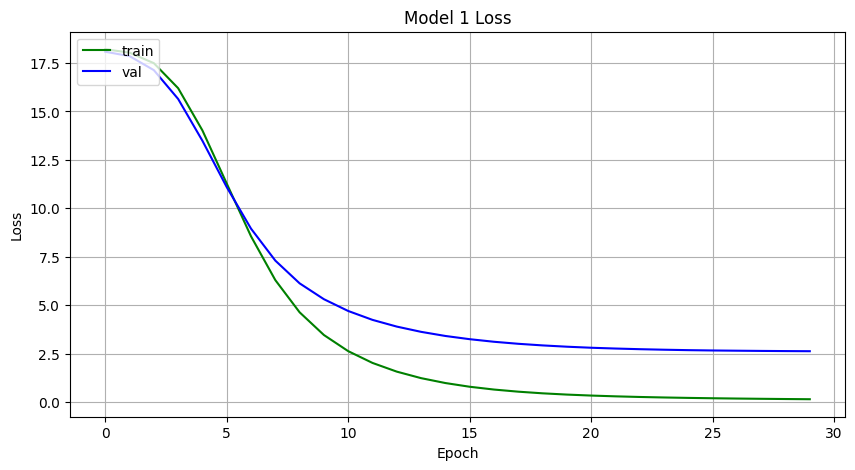

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], 'g')
plt.plot(history1.history['val_loss'], 'b')
plt.title('Model 1 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
user_input2 = Input(shape=(1,), name='user_input2', dtype='int64')
user_embedding2 = Embedding(n_users, latent_factors, name='user_embedding2')(user_input2)
user_vec2 = Flatten(name='FlattenUsers2')(user_embedding2)
user_vec2 = Dropout(0.4)(user_vec2)

product_input2 = Input(shape=(1,), name='product_input2', dtype='int64')
product_embedding2 = Embedding(n_products, latent_factors, name='product_embedding2')(product_input2)
product_vec2 = Flatten(name='FlattenProducts2')(product_embedding2)
product_vec2 = Dropout(0.4)(product_vec2)

sim2 = dot([user_vec2, product_vec2], name='Similarity-Dot-Product2', axes=1)
nn_inp = Dense(96, activation='relu')(sim2)
nn_inp = Dropout(0.4)(nn_inp)
nn_inp = Dense(1, activation='relu')(nn_inp)
model2 = Model([user_input2, product_input2], nn_inp)
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [ ]:
history2 = model2.fit([train['UserId'], train['ProductId']], train['rating'],
                      batch_size=128, epochs=10,
                      validation_data=([test['UserId'], test['ProductId']], test['rating']),
                      verbose=1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 17.0056 - val_loss: 12.8243
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.1508 - val_loss: 5.7525
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5716 - val_loss: 1.9269
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7441 - val_loss: 1.1460
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1285 - val_loss: 1.0316
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8971 - val_loss: 0.9433
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7439 - val_loss: 0.9052
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6441 - val_loss: 0.8849
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5874 - val_loss: 0.8540
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5799 - val_loss: 0.8407


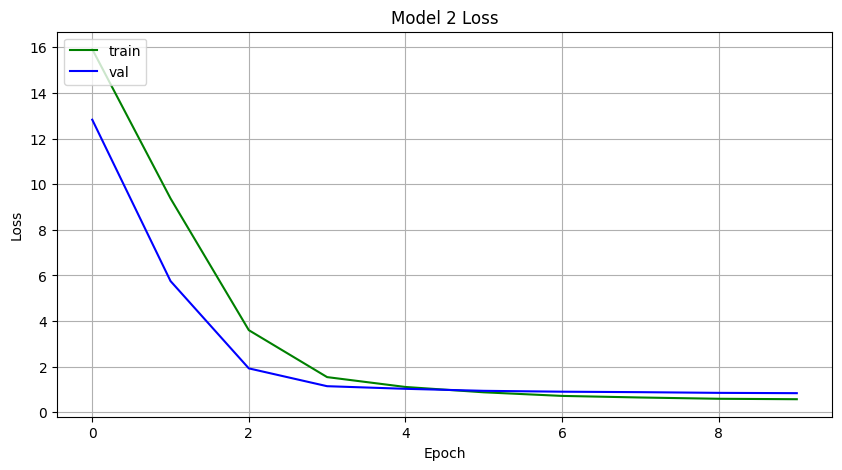

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], 'g')
plt.plot(history2.history['val_loss'], 'b')
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
pred1 = model1.predict([test['UserId'], test['ProductId']])
mse1 = mean_squared_error(test['rating'], pred1)
print(f'MSE для модели 1: {mse1}')

pred2 = model2.predict([test['UserId'], test['ProductId']])
mse2 = mean_squared_error(test['rating'], pred2)
print(f'MSE для модели 2: {mse2}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE для модели 1: 2.6274077892303467
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
MSE для модели 2: 0.8407225012779236


In [ ]:
import random

def recommend_for_random_user(model, n_products, df, df_filtered, userid2idx, productid2idx, top_k=5):
    idx2userid = {i: o for o, i in userid2idx.items()}
    idx2productid = {i: o for o, i in productid2idx.items()}
    user_idx = random.randint(0, len(userid2idx) - 1)
    user_id = idx2userid[user_idx]
    user_ratings = df[df['UserId'] == user_id][['ProductId', 'rating']].sort_values('rating', ascending=False).head(top_k)
    rated_products = set(df_filtered[df_filtered['UserId'] == user_idx]['ProductId'])
    candidates = np.array([p for p in range(n_products) if p not in rated_products], dtype=np.int64)
    inputs = [np.full(len(candidates), user_idx, dtype=np.int64).reshape(-1, 1), candidates.reshape(-1, 1)]
    preds = model.predict(inputs, batch_size=128).flatten()
    top_indices = np.argsort(preds)[-top_k:][::-1]
    print(f"\nПользователь: {user_id}")
    print("\nТоп-5 его оценок:")
    print(user_ratings.to_string(index=False))
    print("\nРекомендации новых продуктов:")
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {idx2productid[candidates[idx]]}: {preds[idx]:.2f}")
    return candidates[top_indices], preds[top_indices]

rec_products, rec_scores = recommend_for_random_user(model2, n_products, df, df_filtered, userid2idx, productid2idx)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Пользователь: A2YIO225BTKVPU

Топ-5 его оценок:
 ProductId  rating
B0029J9U8S       5
B003XUJ3RK       5
B003MULV4O       5
B001YXNZ5O       5
B004EWAPCS       5

Рекомендации новых продуктов:
1. B007RTR9E2: 4.44
2. B007I7YZJK: 4.43
3. B006VRTQZG: 4.41
4. B007I7Z3Z0: 4.39
5. B001EO5U3I: 4.38
